In [99]:
import pandas as pd
import scipy
from scipy import io
import numpy as np
import tensorflow as tf
from keras.models import load_model
import sys;
from esinet.evaluate import eval_mse
# sys.path.insert(0, '../')
from esinet import Simulation, Net, util, evaluate
from forward import create_forward_model, get_info
from matplotlib import pyplot as plt
from esinet.util import calculate_source
import pickle
import tensorflow.keras.backend as K

In [100]:
def custom_prep_data(data):

    data = np.swapaxes(data, 1,2)

    # 获取数据维度
    num_samples, num_timepoints, num_channels = data.shape
    
    # 将数据类型转换为 np.float32
    data = data.astype(np.float32)
    
    # 对每个样本（脑电信号的一个时间点）进行处理
    for i in range(num_samples):
        for j in range(num_timepoints):
            # 获取当前样本的数据
            sample_data = data[i, j, :]
            
            # 假设你想要进行去除平均值和标准化的预处理
            # 去除平均值
            sample_data_mean = np.mean(sample_data)
            sample_data_std = np.std(sample_data)
            sample_data -= sample_data_mean
            
            # 标准化
            if sample_data_std != 0:
                sample_data /= sample_data_std
        
            # 更新数据
            data[i, j, :] = sample_data
    print("The shape of EEG is", data.shape)
    
    return data

# 对源信号进行归一化
def custom_prep_source(data):
    
    # 将数据类型转换为 np.float32
    data = data.astype(np.float32)
    
    for i, y_sample in enumerate(data):
        max_abs_vals=np.array(np.max(abs(data[i])))
        max_abs_vals[max_abs_vals == 0] = 1
        data[i] /= max_abs_vals   

    print("The shape of source is", data.shape)
    
    return data

def make_3d(matrix):
    # 如果矩阵的维度不是3，则增加一个维度
    if matrix.ndim != 3:
        # 在前面增加一个维度
        nrow, ncol = matrix.shape
        matrix_3d = matrix.reshape((1, nrow, ncol))
        return matrix_3d
    else:
        return matrix

def wight_combined_loss(y_true, y_pred):
    
    # # 设定权重
    # binary_array=tf.where(y_true != 0, 1, 0)
    # binary_array = tf.cast(binary_array, dtype=tf.float32)
    # y_true_filtered = tf.multiply(binary_array, y_true)
    # y_pred_filtered = tf.multiply(binary_array, y_pred)

    # 创建一个掩码，标记非零值
    mask = tf.not_equal(y_true, 0)
    # 使用掩码过滤出非零元素
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)

    # MSE Loss
    huber = tf.keras.losses.Huber()(y_true, y_pred)
    huber2 = tf.keras.losses.MeanSquaredError()(y_true_filtered, y_pred_filtered)
    
    # Cosine Similarity Loss
    # 使用 tf.keras.losses.cosine_similarity，并确保结果为正值
    cosine_loss = 1+tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    
    # 组合损失，确保使用 tf.cast 保持类型一致
    combined = 1* huber + 1*cosine_loss
    #combined = 1000 * huber + cosine_loss + huber2
    #combined = 1000 * huber + huber2

    return combined

def non_zero_mse_loss(y_true, y_pred):

    # 创建一个掩码，标记非零值
    mask = tf.not_equal(y_true, 0)
    
    # 使用掩码过滤出非零元素
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)
    
    # 计算非零元素的均方误差
    # mse = tf.square(y_true_filtered - y_pred_filtered)
    mse = K.mean(K.square(y_true_filtered - y_pred_filtered))
    
    # 返回均方误差的平均值
    return tf.reduce_mean(mse)

def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))
def combined_loss2(y_true, y_pred):

    print(y_pred.shape)
    print(y_true.shape)
    # MSE Loss
    huber = tf.keras.losses.Huber()(y_true, y_pred)

    cosine_loss = sparsity(y_true, y_pred)
    
    # 组合损失，确保使用 tf.cast 保持类型一致
    combined = huber + 0.01 * cosine_loss
    return combined

In [101]:
# 加载数据
loaded_data = np.load('D:/jupyter_note/SWX_source/Simulated_data/x_test10.npy')
y_true = np.load('D:/jupyter_note/SWX_source/Simulated_data/y_test10.npy')
# 从文件中加载 sim_test 对象
with open( 'D:/jupyter_note/SWX_source/Simulated_data/sim10.pkl', 'rb') as file:
    sim_test = pickle.load(file)

# 加载保存的模型
model1 = load_model('D:/jupyter_note/SWX_source/Simulated_data/model_10', compile=False)
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
loss = wight_combined_loss
# 重新编译模型
model1.compile(loss=loss, optimizer=optimizer)
# 打印模型摘要
model1.summary()

data=loaded_data
print(data.shape)
    
# 对输入数据进行预处理
data_processed = make_3d(data)
print(data_processed.shape)
X_test = custom_prep_data(data_processed)

Model: "Simplified_Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, None, 60)]   0           []                               
                                                                                                  
 time_distributed_6 (TimeDistri  (None, None, 60)    3660        ['Input[0][0]']                  
 buted)                                                                                           
                                                                                                  
 dropout_2 (Dropout)            (None, None, 60)     0           ['time_distributed_6[0][0]']     
                                                                                                  
 time_distributed_7 (TimeDistri  (None, None, 128)   7808        ['dropout_2

 multi_head_attention (MultiHea  (None, None, 512)   1050624     ['layer_normalization_2[0][0]',  
 dAttention)                                                      'layer_normalization_2[0][0]']  
                                                                                                  
 add_3 (Add)                    (None, None, 512)    0           ['multi_head_attention[0][0]',   
                                                                  'add_2[0][0]']                  
                                                                                                  
 BiLSTM1 (Bidirectional)        (None, None, 1024)   4198400     ['add_3[0][0]']                  
                                                                                                  
 BiLSTM2 (Bidirectional)        (None, None, 1024)   6295552     ['BiLSTM1[0][0]']                
                                                                                                  
 Direct_Ou

In [102]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
import time

# 将脑源活动可视化
plot_params = dict(surface='white', initial_time=0.05, views=('lateral'), hemi='both', colorbar=None, background='white', verbose=0)
start_time = time.time()
y_pred = model1.predict(X_test) # 用于对测试数据进行预测，得到预测值y_hat
end_time = time.time()  # 记录结束时间
print(f"运行时间：{end_time - start_time} 秒")

y_pred1 = np.swapaxes(y_pred, 1, 2) # 得到的源信号维度(n_samples,n_channels, n_times)
y_hat = y_pred1[3] # 提取其中一个实例进行可视化，x_test1_10源用3 6，3源用4,11  2源用16 20  1源用40
print(y_hat.shape)

y_true = custom_prep_source(y_true)

stc = sim_test.source_data[3]
#stc.data = y_true[1]
stc.plot(**plot_params)#通过stc.plot将模拟的真实脑源活动可视化
print(stc.data.shape)
stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat
stc_hat.plot(**plot_params)#将神经网络模型的预测结果可视化，通过 stc_hat.plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
运行时间：3.645609140396118 秒
(1284, 26)
The shape of source is (1000, 1284, 26)
(1284, 26)


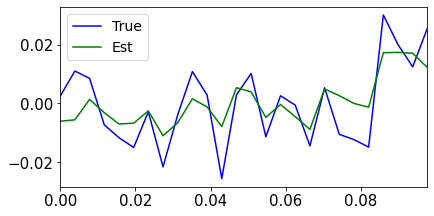

In [103]:
stc.data = y_true[3] # 1源用45画图
plt.figure()
plt.axes([0.1, 0.275, 0.85, 0.625])
hl = plt.plot(stc.times, stc.data.mean(0), "b", label="True")[0]
hr = plt.plot(stc.times, stc_hat.data.mean(0), "g", label="Est")[0]
#plt.xlabel("Time (s)")
#plt.ylabel("Source amplitude")
plt.xlim(stc.times[0], stc.times[-1])
plt.tick_params(axis='x', labelsize=15)  # 设置x轴刻度标签的大小为14
plt.tick_params(axis='y', labelsize=15)  # 设置y轴刻度标签的大小为14
plt.legend(fontsize=14)  # 显示图例
plt.savefig('transformer.tif', dpi=300)  # 保存为 PNG 格式

In [104]:
# 打印基本信息
print("STC 类型:", type(stc))
print("STC 数据维度:", stc.data.shape)  # 数据的形状，例如 (顶点数, 时间点数)
print("STC 时间点数:", len(stc.times))  # 时间点的数量
print("STC 采样率:", stc.sfreq)         # 采样频率

# 假设 stc_hat 是一个包含脑源活动数据的 SourceEstimate 对象
# 计算每个顶点的平均激活强度
average_activations = np.mean(stc_hat.data, axis=1)
# 获取顶点索引和对应的平均激活强度
vertex_activation_pairs = list(enumerate(average_activations))
# 根据激活强度对顶点进行排序
vertex_activation_pairs.sort(key=lambda x: x[1], reverse=True)  # 按照激活强度从高到低排序
# 输出前几个最活跃的脑区
for vertex, activation in vertex_activation_pairs[:10]:  # 这里以前10个最活跃的脑区为例
    print(f"Vertex {vertex} has an average activation of {activation}")

STC 类型: <class 'mne.source_estimate.SourceEstimate'>
STC 数据维度: (1284, 26)
STC 时间点数: 26
STC 采样率: 256.0
Vertex 519 has an average activation of 0.17230956256389618
Vertex 518 has an average activation of 0.15952445566654205
Vertex 119 has an average activation of 0.1543060839176178
Vertex 516 has an average activation of 0.15304867923259735
Vertex 520 has an average activation of 0.13537774980068207
Vertex 25 has an average activation of 0.12245833873748779
Vertex 118 has an average activation of 0.11781525611877441
Vertex 427 has an average activation of 0.11257850378751755
Vertex 261 has an average activation of 0.10448232293128967
Vertex 259 has an average activation of 0.09992446005344391


In [105]:
# 打印最强源的坐标
pos = np.load('pos_128.npy')
# 打印加载后的数组
print(pos.shape)
source_positions = pos
# 打印所有的输出，而不是只显示前几个
np.set_printoptions(threshold=np.inf)
num_sources = len(source_positions)
print("Number of Source Positions:", num_sources)
# 获取排序后的索引
sorted_indices = np.argsort(average_activations)[::-1]
# 根据排序后的索引输出激活强度
# sorted_activation = average_activations[sorted_indices]
# print("Sorted activation based on average activation:")
# print(sorted_activation)
# print("\nSorted indices based on average activation:")
# print(sorted_indices)
# 输出对应的源坐标
print("\nCorresponding source positions:")
for idx in sorted_indices[:10]: # 这里以前10个最活跃的脑区为例
    print(source_positions[idx])

(1284, 3)
Number of Source Positions: 1284

Corresponding source positions:
[-10.28431511  38.67029572 -20.37948227]
[-13.48847389  47.80538177 -20.06515884]
[ -4.36631632  48.01567841 -21.0237484 ]
[-18.10874557  35.40290451 -18.70388031]
[ -3.53073931  36.0792923  -23.82230759]
[-15.04815483  27.35552979 -20.76482391]
[-23.27563477  42.19315338 -10.72882271]
[ -9.32681847  27.2803688  -20.00118637]
[-10.90376282  41.41490555 -11.47847366]
[ -7.1460824   59.59489822 -15.99361229]


In [106]:
# 对结果进行评价
from esinet.evaluate import auc_metric
y_true = np.swapaxes(y_true, 1,2)
# 调用 auc_metric 函数，计算平均AUC，注意这里的y_true 维度: (1000, 25, 1284)，y_pred 维度: (1000, 25, 1284)
#mean_auc = auc_metric(y_true, y_pred)
# 输出平均 AUC
#print("平均 AUC across samples:", mean_auc)
#del mean_auc

In [107]:
# 计算多个样本的 NMSE
from esinet.evaluate import eval_nmse

nmse_values = []

for y_true_, y_pred_ in zip(y_true, y_pred):
    
    # 计算每个样本的 NMSE
    nmse_sample = eval_nmse(y_true_, y_pred_)
    nmse_values.append(nmse_sample)

# 计算平均 MSE 和 NMSE
mean_nmse = np.mean(nmse_values)

# 计算标准差
nmse_std = np.std(nmse_values)

# 输出结果
np.savetxt('NMSE.csv', nmse_values, fmt='%.5f')
print("平均 NMSE across samples:", mean_nmse)
print("NMSE 的标准差:", nmse_std)

平均 NMSE across samples: 0.0016097777
NMSE 的标准差: 0.0014648132


In [108]:
# # 计算多个样本的 MLE
from esinet.evaluate import eval_mean_localization_error

def evals(y_true, y_hat, pos):
    n_samples, n_time = y_true.shape[:2]
    n_samples = int(n_samples/5)   # 节省时间
    mles = np.zeros((n_samples,))

    for i in range(n_samples):
        sample_mles = np.zeros((n_time,))

        for j in range(n_time):
            sample_mles[j] = eval_mean_localization_error(y_true[i, j], y_hat[i, j], pos)

        # 在计算平均值之前检查 sample_mles 是否为空
        if not np.isnan(sample_mles).all():
            mles[i] = np.nanmean(sample_mles)

    # 对样本取平均值
    avg_mle = np.nanmean(mles)

    # 计算标准差
    mle_std = np.nanstd(mles)

    return mles, avg_mle, mle_std

# 调用 evals 函数并打印结果
mles, avg_mle_result, mle_std_result = evals(y_true, y_pred, pos)
np.savetxt('MLE.csv', mles, fmt='%.5f')
print("模型1—平均 MLE across samples:", avg_mle_result)
print("MLE 的标准差:", mle_std_result)

模型1—平均 MLE across samples: 12.84346973086362
MLE 的标准差: 7.033605987745047


In [109]:
# 计算多个样本的 AUC
from esinet.evaluate import auc_metric
# 调用 auc_metric 函数，计算平均AUC，注意这里的y_true 维度: (1000, 25, 1284)，y_pred 维度: (1000, 25, 1284)
auc_values = []

for y_true_, y_pred_ in zip(y_true, y_pred):
    
    # 计算每个样本的 NMSE
    auc_sample,auc_std = auc_metric(y_true_, y_pred_)
    auc_values.append(auc_sample)

# 计算平均 MSE 和 NMSE
mean_auc = np.mean(auc_values)

# 计算标准差
std_auc = np.std(auc_values)

# 输出平均 AUC
np.savetxt('AUC.csv', auc_values, fmt='%.5f')
print("平均 AUC across samples:", mean_auc)
print("AUC 的标准差:", std_auc)

平均 AUC across samples: 0.9440413857611518
AUC 的标准差: 0.06301949696095935


In [110]:
##计算每一个样本的相关性和p值，找到相关性最强的样本，并将这个样本的预测脑图和真实脑图进行绘制
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
# 模型预测和评估：
best_sample_idx_model = None
best_r_model = -1  # 初始值设为一个较小的值，确保它会被更新
best_p_value_model = 1  # 初始值设为一个较大的值，确保它会被更新
average_r_model = 0  # 初始化累计变量
correlations=[]
n_samples, n_time = y_true.shape[:2]

for idx in tqdm(range(n_samples)):
    n = sim_test.simulation_info["number_of_sources"].values[idx]
    #print(f"{n} source(s)")

    # 模型1的预测和评估
    r_model, p_value_model = pearsonr(y_pred[idx].flatten(), y_true[idx].flatten())
    correlations.append(np.abs(r_model))

    # 更新最佳样本信息
    if r_model > best_r_model:
        best_r_model = r_model
        best_p_value_model = p_value_model
        best_sample_idx_model = idx
         # 累计结果
    average_r_model += r_model

# 计算平均值
np.savetxt('CC.csv', correlations, fmt='%.5f')
average_r_model /= n_samples
variance_r_model = np.std(correlations)
print(f"model1: Average r={average_r_model:.2f}")
print(f"model1: Average r={variance_r_model:.2f}")
# 输出每个模型的最佳样本信息
# print(f"Best Sample Index - {model1.name}: {best_sample_idx_model}")
# print(f"{model1.name}: r={best_r_model:.2f}, p-value={best_p_value_model:.4f}")
# 使用每个模型的最佳样本的结果进行脑图可视化
#stc = sim_test.source_data[best_sample_idx_model1]

  0%|          | 0/1000 [00:00<?, ?it/s]

model1: Average r=0.72
model1: Average r=0.18


In [111]:
# 计算AUC_close指标
# from esinet.evaluate import eval_auc
# def calculate_avg_auc_close_with_std(y_true, y_hat, pos):
#     n_samples = y_true.shape[0]
#     n_time = y_true.shape[1]
#     n_samples = int(n_samples/2)   # 节省时间
#     aucs_close = np.zeros((n_samples, n_time))

#     for i in range(n_samples):
#         sample_aucs_close = np.zeros((n_time,))

#         for j in range(n_time):
#             auc_close, _ = eval_auc(y_true[i, j], y_hat[i, j], pos)
#             sample_aucs_close[j] = auc_close

#         # Take the mean across time for each sample
#         aucs_close[i] = sample_aucs_close

#     # Take the mean across samples
#     avg_auc_close = np.mean(aucs_close)
#     auc_close_std = np.std(aucs_close)

#     return avg_auc_close, auc_close_std

# 使用新的函数计算 avg_auc_close 和标准差
# avg_auc_close_result, auc_close_std_result = calculate_avg_auc_close_with_std(y_true, y_pred, pos)
# # 输出结果
# print("模型1—平均 AUC_close across samples:", avg_auc_close_result)
# print("AUC_close 的标准差:", auc_close_std_result)

In [112]:
# 计算AUC_far指标
# def calculate_avg_auc_far_with_std(y_true, y_hat, pos):
#     n_samples = y_true.shape[0]
#     n_time = y_true.shape[1]
#     n_samples = int(n_samples/2)   # 节省时间
#     aucs_far = np.zeros((n_samples, n_time))

#     for i in range(n_samples):
#         sample_aucs_far = np.zeros((n_time,))

#         for j in range(n_time):
#             _, auc_far = eval_auc(y_true[i, j], y_hat[i, j], pos)
#             sample_aucs_far[j] = auc_far

#         # Take the mean across time for each sample
#         aucs_far[i] = sample_aucs_far

#     # Take the mean across samples
#     avg_auc_far = np.mean(aucs_far)
#     auc_far_std = np.std(aucs_far)

#     return avg_auc_far, auc_far_std

# 使用新的函数计算 avg_auc_far 和标准差
# avg_auc_far_result, auc_far_std_result = calculate_avg_auc_far_with_std(y_true, y_pred, pos)

# # 输出结果
# print("模型1—平均 AUC_far across samples:", avg_auc_far_result)
# print("AUC_far 的标准差:", auc_far_std_result)